# GDSCv2 Interpretation

This notebook shows some example on how to interpret the output from the Bayesian model to infer responses of basket/cluster combinations.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append('..')
sys.path.append('.')

In [3]:
from pyBasket.common import load_obj
from pyBasket.interpret import get_predicted_basket_df, get_basket_cluster_prob_df, find_top_k_indices, find_bottom_k_indices
from pyBasket.interpret import select_partition, plot_responsive_count, get_member_expression, ttest_dataframe
from pyBasket.interpret import plot_expression_boxplot, df_diff, plot_basket_probs, plot_basket_cluster_heatmap
from pyBasket.clustering import plot_PCA

# Load results

Load previously saved results

In [4]:
drug_name = 'Erlotinib'
C = 5

In [5]:
input_dir = 'results'
file_name = 'patient_analysis_%s_cluster_%d.p' % (drug_name, C)
save_data = load_obj(os.path.join(input_dir, file_name))

In [6]:
list(save_data.keys())

['expr_df_filtered',
 'expr_df_selected',
 'drug_response',
 'class_labels',
 'cluster_labels',
 'patient_df',
 'stacked_posterior',
 'trace',
 'importance_df']

# Things to show in the viz

## Basket probabilities

In [7]:
predicted_basket_df = get_predicted_basket_df(save_data)
predicted_basket_df

,prob
Biliary Tract,0.758115
Bladder/Urinary Tract,0.768532
Bone,0.744535
Bowel,0.762963
Breast,0.754035
Cervix,0.611221
CNS/Brain,0.787720
Esophagus/Stomach,0.757348
Head and Neck,0.570199
Kidney,0.680731


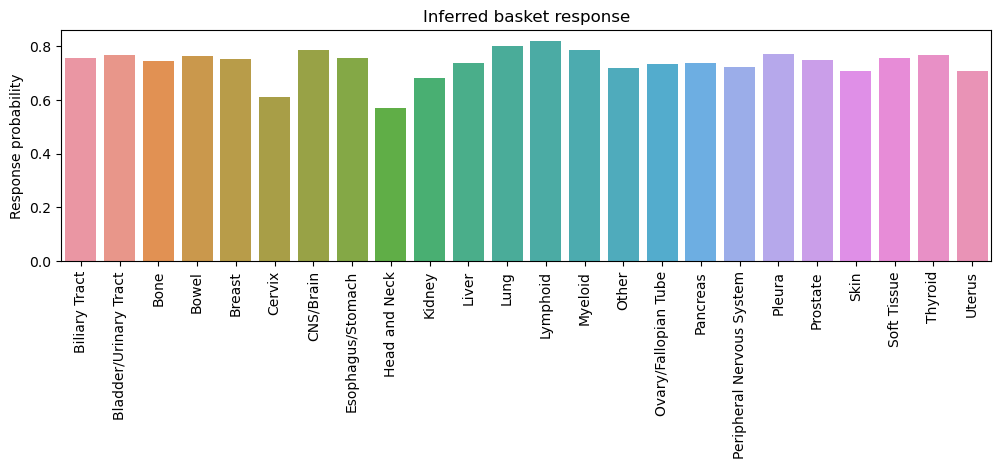

In [8]:
plot_basket_probs(predicted_basket_df)

## Overall heatmap

In [9]:
inferred_df = get_basket_cluster_prob_df(save_data)

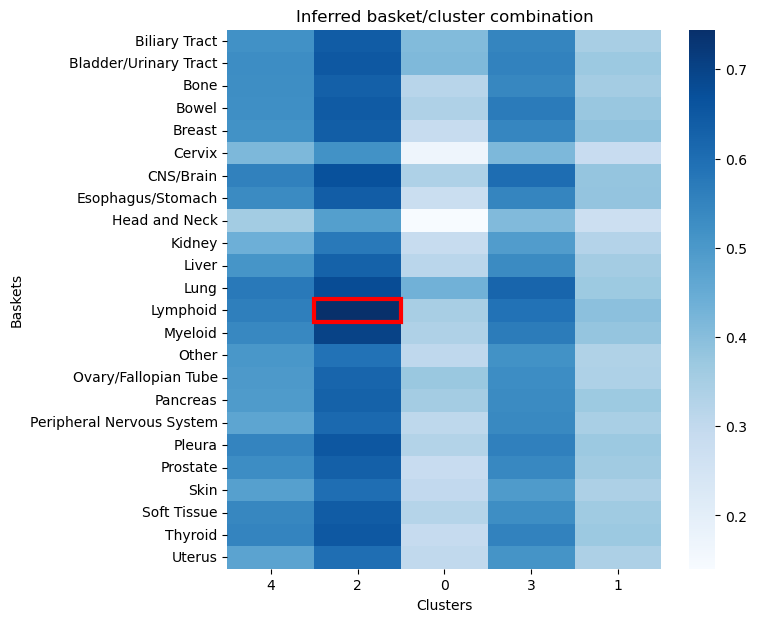

In [10]:
plot_basket_cluster_heatmap(inferred_df, 1, 12)

# Any interesting data to look at?

## Which basket/cluster combinations have the highest / lowest response rates?

In [11]:
top_df = find_top_k_indices(save_data, 10)
top_df

,basket_idx,cluster_idx,basket,cluster,probability,count
0,12,1,Lymphoid,2,0.744334,0
1,13,1,Myeloid,2,0.700154,0
2,11,1,Lung,2,0.678941,3
3,6,1,CNS/Brain,2,0.667333,0
4,18,1,Pleura,2,0.653710,0
5,1,1,Bladder/Urinary Tract,2,0.651547,3
6,22,1,Thyroid,2,0.650086,1
7,3,1,Bowel,2,0.645076,6
8,21,1,Soft Tissue,2,0.641521,0
9,0,1,Biliary Tract,2,0.641061,3


In [12]:
bottom_df = find_bottom_k_indices(save_data, 10)
bottom_df

,basket_idx,cluster_idx,basket,cluster,probability,count
0,8,2,Head and Neck,0,0.140256,4
1,5,2,Cervix,0,0.167283,3
2,8,4,Head and Neck,1,0.273034,0
3,7,2,Esophagus/Stomach,0,0.279265,3
4,19,2,Prostate,0,0.284387,1
5,5,4,Cervix,1,0.285997,0
6,4,2,Breast,0,0.286732,0
7,9,2,Kidney,0,0.287878,5
8,22,2,Thyroid,0,0.291841,6
9,20,2,Skin,0,0.300456,7


## Inspect one partition

In [13]:
query_basket = 'Bowel'
query_cluster = 2
selected_df = select_partition(save_data, query_basket, query_cluster)
selected_df

,tissues,responses,basket_number,cluster_number,responsive
samples,,,,,
SW626,Bowel,0.046229,3,2,1
CaR-1,Bowel,0.067109,3,2,0
SNU-407,Bowel,0.084428,3,2,0
SW837,Bowel,0.068282,3,2,0
SNU-C2B,Bowel,0.052343,3,2,1
SNU-C5,Bowel,0.117986,3,2,0


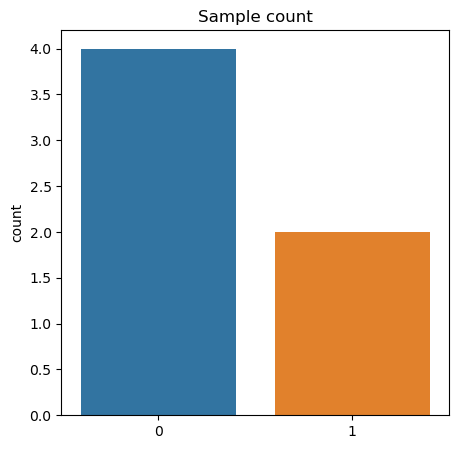

In [14]:
plot_responsive_count(selected_df)

In [15]:
member_df = get_member_expression(selected_df, save_data)
member_df.shape

(6, 500)

PCA explained variance [0.26579413 0.49233062]


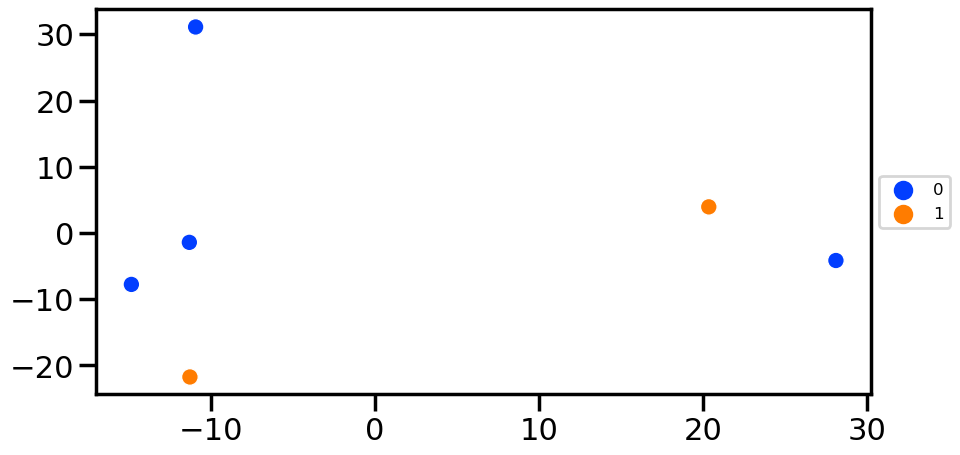

In [16]:
pc1, pc2 = plot_PCA(member_df, hue=selected_df['responsive'], n_components=2)

Pick the first transcript as it has the highest importance score during feature selection.

In [17]:
all_expr_df = df_diff(member_df, save_data['expr_df_selected'])
all_expr_df.shape

(292, 500)

In [18]:
test_df = ttest_dataframe(member_df, all_expr_df, only_significant=True)
test_df

,T-Statistic,P-Value,P-Value (Bonferroni),Significant
Feature,,,,
ENSG00000149043.16,4.408405,0.000015,0.007292,True
ENSG00000170786.12,4.398471,0.000015,0.007613,True
ENSG00000167755.15,4.342141,0.000019,0.009700,True
ENSG00000186509.4,-4.200792,0.000035,0.017621,True
ENSG00000124102.5,3.978757,0.000087,0.043591,True


In [19]:
selected_feature = test_df.index.values[0]
selected_feature

'ENSG00000149043.16'

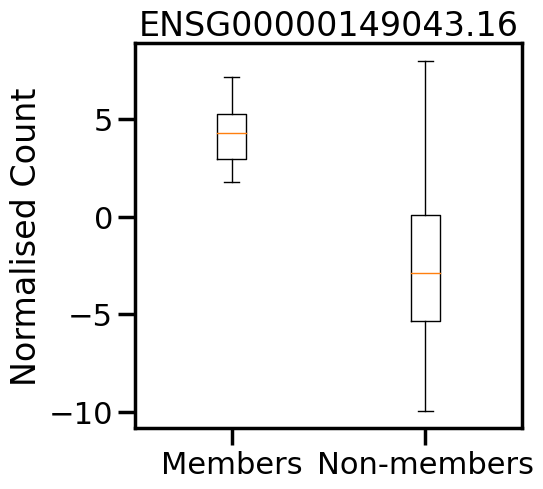

In [20]:
plot_expression_boxplot(selected_feature, member_df, all_expr_df)